# Interpretability techniques for single samples from RVL-CDIP subset - LayoutLMVV3

## GITHUB

In [37]:
!git clone https://github.com/adamserag1/Interpretability-for-VRDU-models.git

Cloning into 'Interpretability-for-VRDU-models'...
remote: Enumerating objects: 1298, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 1298 (delta 22), reused 22 (delta 12), pack-reused 1262 (from 2)
Receiving objects: 100% (1298/1298), 20.41 MiB | 11.10 MiB/s, done.
Resolving deltas: 100% (796/796), done.


In [226]:
!git pull https://github.com/adamserag1/Interpretability-for-VRDU-models.git

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 401 bytes | 401.00 KiB/s, done.
From https://github.com/adamserag1/Interpretability-for-VRDU-models
 * branch            HEAD       -> FETCH_HEAD
Updating 756f2f3..712a6c1
Fast-forward
 Classification_Explain/lime.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [79]:
%cd /content/Interpretability-for-VRDU-models

/content/Interpretability-for-VRDU-models


In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install -U datasets

## Libraries

In [227]:
#code
from datasets import load_from_disk
from transformers import LayoutLMv3ForSequenceClassification, AutoProcessor, BrosModel, AutoTokenizer, BrosPreTrainedModel, AutoConfig
import sys
import importlib
def reload_modules():
    for module in list(sys.modules.keys()):
        if module.startswith('vrdu_utils') or module.startswith('Classification_Explain') or module.startswith('lime') or module.startswith('Eval'):
            print(f"Reloading module: {module}")
            importlib.reload(sys.modules[module])

reload_modules()

from vrdu_utils.encoders import *
from Classification_Explain.lime import *
from vrdu_utils.utils import *
import torch
from Eval.eval_suite import *
from Eval.fidelity import *
from Classification_Explain.shap import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
from transformers import logging as hf_logging

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="transformers.modeling_utils",   # the module that emits the msg
)
hf_logging.set_verbosity_error()


Reloading module: Classification_Explain
Reloading module: Eval.fidelity
Reloading module: Eval.eval_suite
Reloading module: Eval
Reloading module: vrdu_utils.module_types
Reloading module: vrdu_utils.utils
Reloading module: vrdu_utils.encoders
Reloading module: vrdu_utils
Reloading module: lime
Reloading module: lime.discretize
Reloading module: lime.exceptions
Reloading module: lime.explanation
Reloading module: lime.lime_base
Reloading module: lime.lime_tabular
Reloading module: lime.wrappers
Reloading module: lime.utils
Reloading module: lime.utils.generic_utils
Reloading module: lime.wrappers.scikit_image
Reloading module: lime.lime_image
Reloading module: Classification_Explain.lime
Reloading module: Classification_Explain.shap


## Data + Model Setup

In [6]:
from google.colab import drive
drive.mount("/content/drive")
!cp -r /content/drive/MyDrive/THESIS/rvl_cdip_financial_subset /content

Mounted at /content/drive


In [7]:
rvl = load_from_disk('/content/rvl_cdip_financial_subset')
dataset_split = rvl.train_test_split(test_size=0.2, seed=42)
val = dataset_split["test"]
val_ds = DocSampleDataset(val)

# Extract samples 'agree' (LLMV3 + BROS classify correct) and 'CLASH' (LLMV3 classify wrong, BROS classify correct)

AGREE = val_ds[846] # (contents, idx)
CLASH = val_ds[282] # (contents, idx) #282

In [ ]:
AGREE[0].label

4

In [ ]:
CLASH[0].image

### BROSforDocumentClassifcation classifier head


In [185]:
from torch import nn
class BrosForDocumentClassification(BrosPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bros = BrosModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        bbox=None,
        attention_mask=None,
        token_type_ids=None,
        labels=None,
        **kwargs
    ):
        outputs = self.bros(
            input_ids=input_ids,
            bbox=bbox,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        # Use the [CLS] token's representation (first token)
        cls_output = outputs.last_hidden_state[:, 0, :]  # shape: (batch_size, hidden_size)

        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return {
            "loss": loss,
            "logits": logits,
        }

### Model config

In [9]:
LLMV3 = LayoutLMv3ForSequenceClassification.from_pretrained("adamadam111/layoutlmv3-docclass-finetuned-frz",
                                                            num_labels=5,
                                                            id2label={0: "form", 1: "invoice", 2: "budget", 3: "file folder", 4: "questionnaire"},
                                                            label2id={"form": 0, "invoice": 1, "budget": 2, "file folder": 3, "questionnaire": 4})
LLMV3_proc = AutoProcessor.from_pretrained("adamadam111/layoutlmv3-docclass-finetuned-frz", apply_ocr=False)

LLMV3.to(device)

bros_config = AutoConfig.from_pretrained(
    "adamadam111/bros-docclass-finetuned-frz",
    num_labels=5,
    id2label={0: "form", 1: "invoice", 2: "budget", 3: "file folder", 4: "questionnaire"},
    label2id={"form": 0, "invoice": 1, "budget": 2, "file folder": 3, "questionnaire": 4}
)

BROS = BrosForDocumentClassification.from_pretrained(
    "adamadam111/bros-docclass-finetuned-frz",
    config=bros_config
)
BROS_t = AutoTokenizer.from_pretrained("adamadam111/bros-docclass-finetuned-frz",do_lower_case=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/966 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

## Interpreting the 'CLASH' sample

In [10]:
LLMV3_encode = make_layoutlmv3_encoder(LLMV3_proc)
BROS_encode = make_bros_encoder(BROS_t)

### Text Modality


In [ ]:
# for idx, sample in enumerate(val_ds):
#   pred_bros = torch.argmax(BROS(**BROS_encode([sample[0]],device))['logits'], dim=1).item()
#   pred_llmv3 = torch.argmax(LLMV3(**LLMV3_encode([sample[0]], device))['logits'], dim=1).item()
#   if pred_bros != pred_llmv3:
#     print(f'Sample idx: {idx}, prediction BROS: {pred_bros}, prediction LLMV3: {pred_llmv3}, gt: {sample[0].label}')

NameError: name 'BROS_encode' is not defined

In [ ]:
print(CLASH[0].words)

['AUDIT', 'FORM', '-', 'May,', '1994', 'Name:', 'R.', 'Nanmaa', 'Location:', 'Mock', 'Senior', 'Project', 'Leader:,', 'Manager:', 'mf.', 'Nawkins', 'Director:', 'C.', 'bk.', 'atrving', '1.', 'Are', 'files', 'neat,', 'organized,', 'and', 'easily', 'identified?', 'xes__V__No', '16°\'No,"', 'Comments:', 'Ei', 'bigied', 'with', 'categon', 'ou)', 'cody', '=', 'put', 'peed', 'teleAtion', 'periods', '2.', 'Are', 'll', 'ies', '(folders,', 'notebooks,', 'hanging', 'drawings', 'etc.)', 'properly', 'coded?', 'yes__V_No', 'If"No,"', 'Comments:', 'DICK', 'has', 'inv', 'ColeaaritS', 'listd', '.', 'oO', 'iS', 'cp', '(devs', 'Dut', 'naddsto', 'intlucer', 'veleohon', 'Qeviods', 'and', 'pot', 'NOS', 'Cnheve', 'app', 'licanle).', '3.', 'Are', 'categories,', 'codes,', 'and', 'retention', 'periods', 'easily', 'visible?', '+e', 'Numbers', 'are', 'Du', 'Yves', 'ne', 'Thecategory', 'ON', 'ee', 'Have', 'ved', '4.', 'What', 'kinds', 'of', 'files', 'were', 'not', 'properly', 'coded', 'and', 'filed?', '(If', 'app

In [ ]:
!git pull https://github.com/adamserag1/Interpretability-for-VRDU-models.git

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 586 bytes | 586.00 KiB/s, done.
From https://github.com/adamserag1/Interpretability-for-VRDU-models
 * branch            HEAD       -> FETCH_HEAD
Updating 1255bcc..01b3e7f
Fast-forward
 Eval/fidelity.py | 34 +++++++++++++++++++++++++---------
 1 file changed, 25 insertions(+), 9 deletions(-)


In [ ]:
from Classification_Explain.lime import *
from Classification_Explain.shap import *

In [ ]:

text_explainers = {
    'BROS lime' : LimeTextExplainer(BROS, BROS_encode, mask_token=BROS_t.mask_token, kernel_width_factor = 0.75, labels=[4,0]),
    'LLMV3 lime' : LimeTextExplainer(LLMV3, LLMV3_encode, mask_token = LLMV3_proc.tokenizer.mask_token, kernel_width_factor = 0.75, labels = [4,0]),
    'BROS shap' : SHAPTextExplainer(BROS, BROS_encode, BROS_t, mask_token=BROS_t.mask_token, device=device),
    'LLMV3 shap' : SHAPTextExplainer(LLMV3, LLMV3_encode, LLMV3_proc.tokenizer,mask_token=LLMV3_proc.tokenizer.mask_token, device=device)
}

In [ ]:
# RUN FOR
shap_text_explainations = {key : explainer.explain(CLASH[0], nsamples = 4000) for key, explainer in text_explainers.items() if 'shap' in key}
# lime_text_explainations = {key : explainer.explain(CLASH[0], num_samples = 4000) for key, explainer in text_explainers.items() if 'lime' in key}

PermutationExplainer explainer: 2it [00:39, 39.79s/it]               
PermutationExplainer explainer: 2it [01:20, 80.29s/it]               


Removed top 5 words
[COMP] original probability: 0.9907686114311218, perturbed_probability: 0.9923041462898254
Removed top 5 words
[COMP] original probability: 0.9907686114311218, perturbed_probability: 0.9513720870018005
Kept top 5 text tokens
[SUF] original probability: 0.9907686114311218, perturbed_probability: 0.9907591342926025
Kept top 5 text tokens
[SUF] original probability: 0.9907686114311218, perturbed_probability: 0.9954131245613098


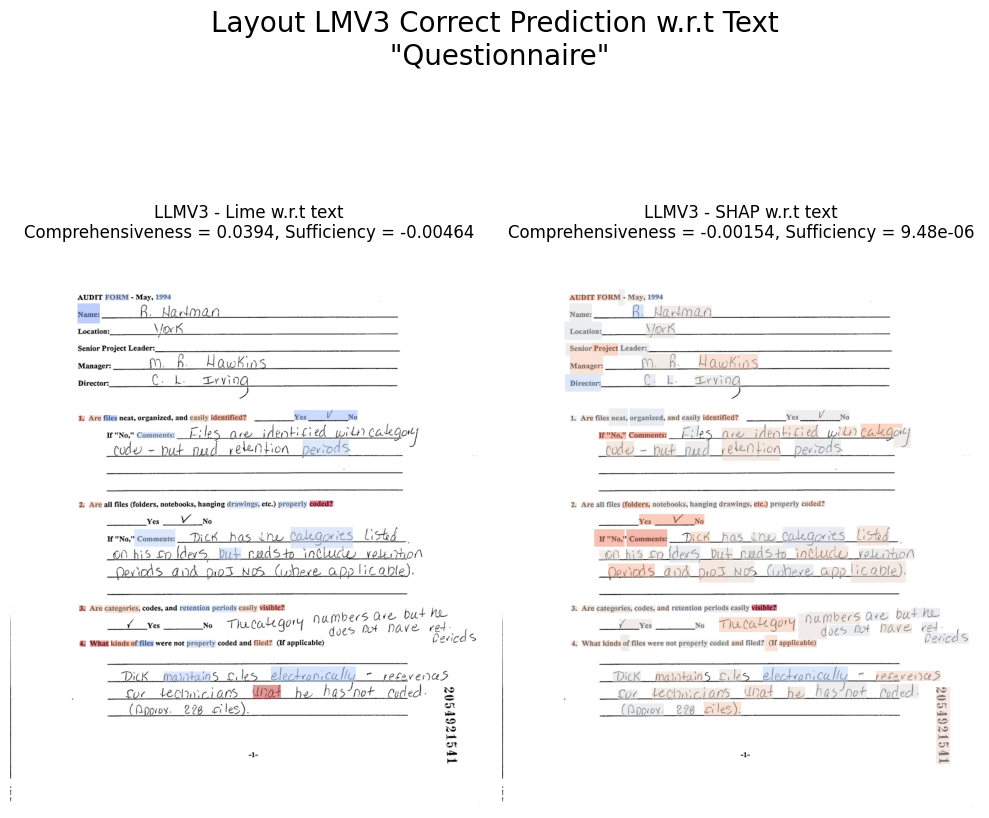

In [ ]:
# Pertaining to label 4 (correct, Questionnaire) (idx 0 shap)
text_explanations_hms = {}
text_explanations_weights = {}
for key, explanation in shap_text_explainations.items():
  weights = {tok : float(val) for tok, val in zip(CLASH[0].words, shap_text_explainations[key].values[:,:,4].flatten())}
  text_explanations_weights.update({key : weights})
  text_explanations_hms.update({key : draw_lime_token_heatmap(image = CLASH[0].image, words = CLASH[0].words, boxes = CLASH[0].bboxes, weights=weights, alpha=0.5) })

for key, explanation in lime_text_explainations.items():
  weights = dict(lime_text_explainations[key].as_list(label=4))
  clean_weights = {key.replace('=1', ''): value for key, value in weights.items()}
  text_explanations_weights.update({key : clean_weights})
  text_explanations_hms.update({key : draw_lime_token_heatmap(image = CLASH[0].image, words = CLASH[0].words, boxes = CLASH[0].bboxes, weights=clean_weights, alpha=0.5) })

# LLMV3 Fidelity
pred_fn_llmv3_s = FidelityEvaluator(LLMV3, LLMV3_encode, mask_token=LLMV3_proc.tokenizer.mask_token)._get_prediction_function(4)
pred_fn_llmv3_l = FidelityEvaluator(LLMV3, LLMV3_encode, mask_token='|~|')._get_prediction_function(4)
comp_s = calculate_comprehensiveness(pred_fn_llmv3_s, CLASH[0], text_explanations_weights['LLMV3 shap'], mask_token='|~|',  top_k=5)
comp_l = calculate_comprehensiveness(pred_fn_llmv3_l, CLASH[0], text_explanations_weights['LLMV3 lime'], mask_token=LLMV3_proc.tokenizer.mask_token,  top_k=5)
suf_s = calculate_sufficiency(pred_fn_llmv3_s, CLASH[0], text_explanations_weights['LLMV3 shap'], mask_token='|~|',  top_k=5)
suf_l = calculate_sufficiency(pred_fn_llmv3_l, CLASH[0], text_explanations_weights['LLMV3 lime'], mask_token=LLMV3_proc.tokenizer.mask_token,  top_k=5)

display_image_grid([text_explanations_hms['LLMV3 lime'], text_explanations_hms['LLMV3 shap']],
                   [f'LLMV3 - Lime w.r.t text\nComprehensiveness = {comp_l:.3g}, Sufficiency = {suf_l:.3g}', f'LLMV3 - SHAP w.r.t text\nComprehensiveness = {comp_s:.3g}, Sufficiency = {suf_s:.3g}'],
                    (1,2),
                   main_title='Layout LMV3 Correct Prediction w.r.t Text\n "Questionnaire"')

Removed top 5 words
[COMP] original probability: 0.9711530208587646, perturbed_probability: 0.9799171090126038
Removed top 5 words
[COMP] original probability: 0.9711530208587646, perturbed_probability: 0.9319615364074707
Kept top 5 text tokens
[SUF] original probability: 0.9711530208587646, perturbed_probability: 0.7315254211425781
Kept top 5 text tokens
[SUF] original probability: 0.9711530208587646, perturbed_probability: 0.2065006047487259


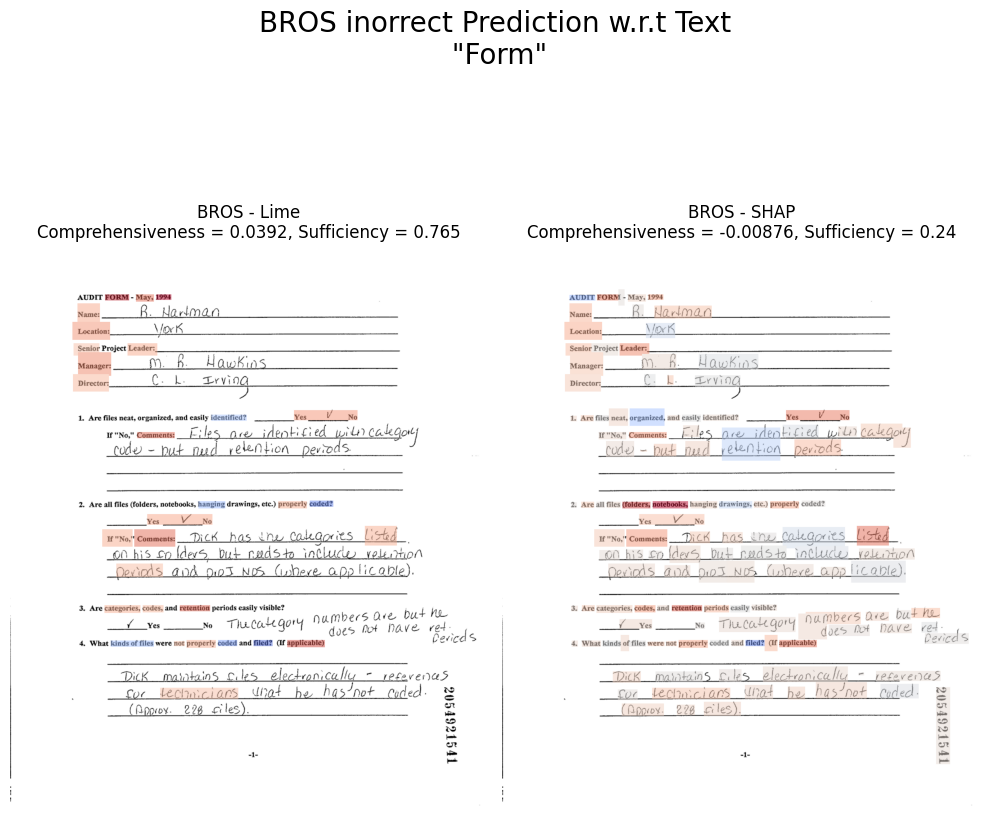

In [ ]:
text_explanations_hms = {}
text_explanations_weights = {}
for key, explanation in shap_text_explainations.items():
  weights = {tok : float(val) for tok, val in zip(CLASH[0].words, shap_text_explainations[key].values[:,:,0].flatten())}
  text_explanations_weights.update({key : weights})
  text_explanations_hms.update({key : draw_lime_token_heatmap(image = CLASH[0].image, words = CLASH[0].words, boxes = CLASH[0].bboxes, weights=weights, alpha=0.5) })

for key, explanation in lime_text_explainations.items():
  weights = dict(lime_text_explainations[key].as_list(label=0))
  clean_weights = {key.replace('=1', ''): value for key, value in weights.items()}
  text_explanations_weights.update({key : clean_weights})
  text_explanations_hms.update({key : draw_lime_token_heatmap(image = CLASH[0].image, words = CLASH[0].words, boxes = CLASH[0].bboxes, weights=clean_weights, alpha=0.5) })

# LLMV3 Fidelity
pred_fn_bros_s = FidelityEvaluator(BROS, BROS_encode, mask_token=BROS_t.mask_token)._get_prediction_function(0)
pred_fn_bros_l = FidelityEvaluator(BROS, BROS_encode, mask_token='|~|')._get_prediction_function(0)
comp_s = calculate_comprehensiveness(pred_fn_bros_s, CLASH[0], text_explanations_weights['BROS shap'], mask_token='|~|',  top_k=5)
comp_l = calculate_comprehensiveness(pred_fn_bros_l, CLASH[0], text_explanations_weights['BROS lime'], mask_token=BROS_t.mask_token, top_k=5)
suf_s = calculate_sufficiency(pred_fn_bros_s, CLASH[0], text_explanations_weights['BROS shap'], mask_token='|~|', top_k=5)
suf_l = calculate_sufficiency(pred_fn_bros_l, CLASH[0], text_explanations_weights['BROS lime'], mask_token=BROS_t.mask_token, top_k=5)

display_image_grid([text_explanations_hms['BROS lime'], text_explanations_hms['BROS shap']],
                   [f'BROS - Lime\nComprehensiveness = {comp_l:.3g}, Sufficiency = {suf_l:.3g}', f'BROS - SHAP\nComprehensiveness = {comp_s:.3g}, Sufficiency = {suf_s:.3g}'],
                    (1,2),
                   main_title='BROS inorrect Prediction w.r.t Text\n "Form"')

In [ ]:
text_explanations_hms = {}
text_explanations_weights = {}
for key, explanation in shap_text_explainations.items():
  weights = {tok : float(val) for tok, val in zip(CLASH[0].words, shap_text_explainations[key].values[:, 0])}
  text_explanations_weights.update({key : weights})
  text_explanations_hms.update({key : draw_lime_token_heatmap(image = CLASH[0].image, words = CLASH[0].words, boxes = CLASH[0].bboxes, weights=weights, alpha=0.5) })

for key, explanation in lime_text_explainations.items():
  weights = dict(lime_text_explainations[key].as_list(label=0))
  clean_weights = {key.replace('=1', ''): value for key, value in weights.items()}
  text_explanations_weights.update({key : clean_weights})
  text_explanations_hms.update({key : draw_lime_token_heatmap(image = CLASH[0].image, words = CLASH[0].words, boxes = CLASH[0].bboxes, weights=clean_weights, alpha=0.5) })

In [ ]:
## Pertaining to label 0 (incorrect, Form)

## Layout

In [ ]:
layout_explainers = {
    'BROS lime' : LimeLayoutExplainer(BROS, BROS_encode, mask_token=BROS_t.mask_token, kernel_width_factor = 0.75, labels=[4,0]),
    'LLMV3 lime' : LimeLayoutExplainer(LLMV3, LLMV3_encode, mask_token = LLMV3_proc.tokenizer.mask_token, kernel_width_factor = 0.75, labels = [4,0]),
    'BROS shap' : SHAPLayoutExplainer(BROS, BROS_encode, device=device),
    'LLMV3 shap' : SHAPLayoutExplainer(LLMV3, LLMV3_encode, device=device)
}

In [ ]:
shap_layout_explainations = {key : explainer.explain(CLASH[0], nsamples = 4000) for key, explainer in layout_explainers.items() if 'shap' in key}
lime_layout_explainations = {key : explainer.explain(CLASH[0], num_samples = 4000) for key, explainer in layout_explainers.items() if 'lime' in key}

Begging EXPLAINER
Begging EXPLAIN_INSTANCE


[LIME] - Text: 100%|██████████| 250/250 [00:41<00:00,  6.09it/s]


Begging EXPLAINER
Begging EXPLAIN_INSTANCE


[LIME] - Text: 100%|██████████| 250/250 [01:25<00:00,  2.93it/s]


Removed top 10 words
[COMP] original probability: 0.9907686114311218, perturbed_probability: 0.993809163570404
Removed top 10 words
[COMP] original probability: 0.9907686114311218, perturbed_probability: 0.993809163570404
Kept top 5 layout tokens
[SUF] original probability: 0.9907686114311218, perturbed_probability: 0.93351149559021
Kept top 5 layout tokens
[SUF] original probability: 0.9907686114311218, perturbed_probability: 0.93351149559021


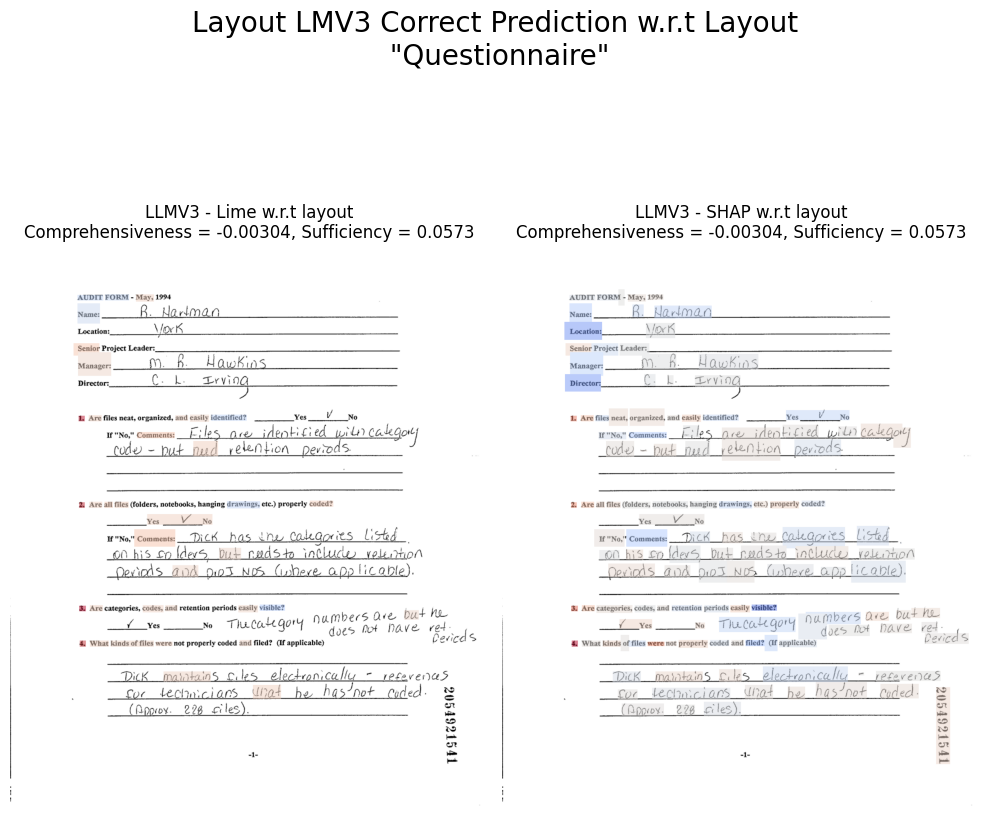

In [ ]:
# Pertaining to label 4 (correct, Questionnaire) (idx 0 shap)
layout_explanations_hms = {}
layout_explanations_weights = {}
for key, explanation in shap_layout_explainations.items():
  weights = {tok : float(val) for tok, val in zip(CLASH[0].words, shap_layout_explainations[key].values[:,:,4].flatten())}
  layout_explanations_weights.update({key : weights})
  layout_explanations_hms.update({key : draw_lime_token_heatmap(image = CLASH[0].image, words = CLASH[0].words, boxes = CLASH[0].bboxes, weights=weights, alpha=0.5) })

for key, explanation in lime_layout_explainations.items():
  weights = dict(lime_layout_explainations[key].as_list(label=4))
  clean_weights = {key.replace('=1', ''): value for key, value in weights.items()}
  layout_explanations_weights.update({key : clean_weights})
  layout_explanations_hms.update({key : draw_lime_token_heatmap(image = CLASH[0].image, words = CLASH[0].words, boxes = CLASH[0].bboxes, weights=clean_weights, alpha=0.5) })

# LLMV3 Fidelity
pred_fn_llmv3_s = FidelityEvaluator(LLMV3, LLMV3_encode, mask_token=LLMV3_proc.tokenizer.mask_token)._get_prediction_function(4)
pred_fn_llmv3_l = FidelityEvaluator(LLMV3, LLMV3_encode, mask_token='|~|')._get_prediction_function(4)
comp_s = calculate_comprehensiveness(pred_fn_llmv3_s, CLASH[0], layout_explanations_weights['LLMV3 shap'], mask_token=LLMV3_proc.tokenizer.mask_token,  top_k=10, modality='layout')
comp_l = calculate_comprehensiveness(pred_fn_llmv3_l, CLASH[0], layout_explanations_weights['LLMV3 lime'], mask_token=LLMV3_proc.tokenizer.mask_token,  top_k=10,modality='layout')
suf_s = calculate_sufficiency(pred_fn_llmv3_s, CLASH[0], layout_explanations_weights['LLMV3 shap'], LLMV3_proc.tokenizer.mask_token,  top_k=5,modality='layout')
suf_l = calculate_sufficiency(pred_fn_llmv3_l, CLASH[0], layout_explanations_weights['LLMV3 lime'], mask_token=LLMV3_proc.tokenizer.mask_token,  top_k=5,modality='layout')

display_image_grid([layout_explanations_hms['LLMV3 lime'], layout_explanations_hms['LLMV3 shap']],
                   [f'LLMV3 - Lime w.r.t layout\nComprehensiveness = {comp_l:.3g}, Sufficiency = {suf_l:.3g}', f'LLMV3 - SHAP w.r.t layout\nComprehensiveness = {comp_s:.3g}, Sufficiency = {suf_s:.3g}'],
                    (1,2),
                   main_title='Layout LMV3 Correct Prediction w.r.t Layout\n "Questionnaire"')

Removed top 10 words
[COMP] original probability: 0.9711530208587646, perturbed_probability: 0.9657066464424133
Removed top 5 words
[COMP] original probability: 0.9711530208587646, perturbed_probability: 0.966955840587616
Kept top 5 layout tokens
[SUF] original probability: 0.9711530208587646, perturbed_probability: 0.9443014860153198
Kept top 5 layout tokens
[SUF] original probability: 0.9711530208587646, perturbed_probability: 0.9443014860153198


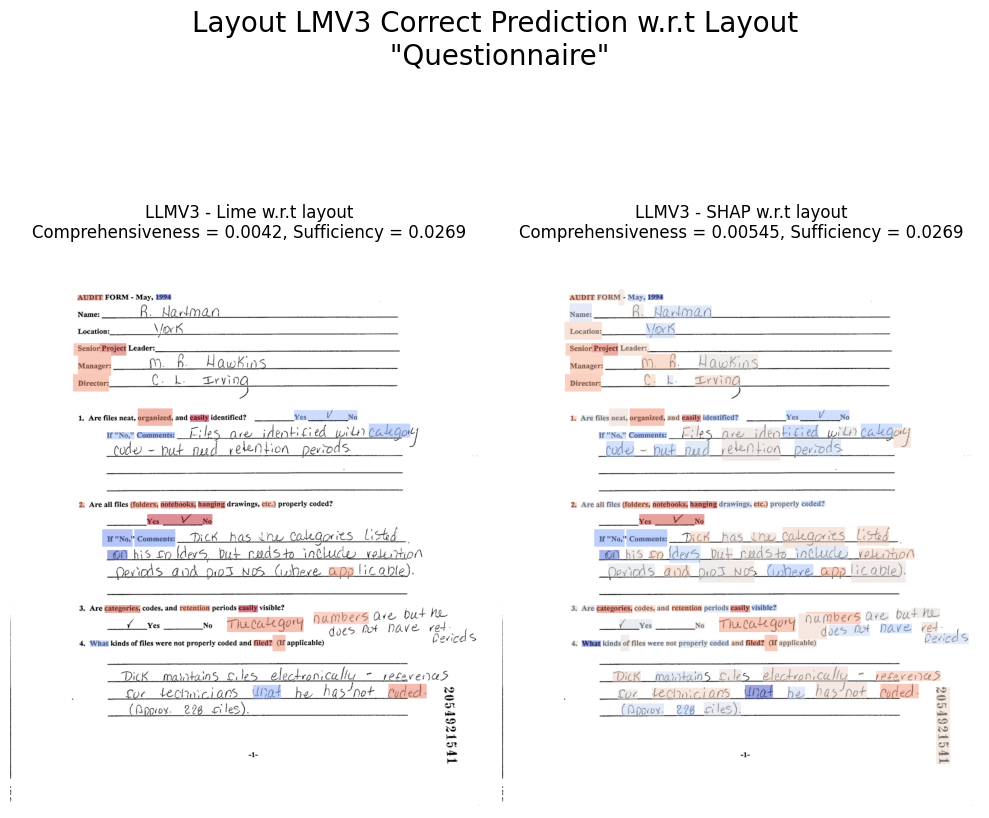

In [ ]:
# Pertaining to label 4 (correct, Questionnaire) (idx 0 shap)
layout_explanations_hms = {}
layout_explanations_weights = {}
for key, explanation in shap_layout_explainations.items():
  weights = {tok : float(val) for tok, val in zip(CLASH[0].words, shap_layout_explainations[key].values[:,:,0].flatten())}
  layout_explanations_weights.update({key : weights})
  layout_explanations_hms.update({key : draw_lime_token_heatmap(image = CLASH[0].image, words = CLASH[0].words, boxes = CLASH[0].bboxes, weights=weights, alpha=0.5) })

for key, explanation in lime_layout_explainations.items():
  weights = dict(lime_layout_explainations[key].as_list(label=0))
  clean_weights = {key.replace('=1', ''): value for key, value in weights.items()}
  layout_explanations_weights.update({key : clean_weights})
  layout_explanations_hms.update({key : draw_lime_token_heatmap(image = CLASH[0].image, words = CLASH[0].words, boxes = CLASH[0].bboxes, weights=clean_weights, alpha=0.5) })

# LLMV3 Fidelity
pred_fn_bros_s = FidelityEvaluator(BROS, BROS_encode, mask_token=BROS_t.mask_token)._get_prediction_function(0)
pred_fn_bros_l = FidelityEvaluator(BROS, BROS_encode, mask_token=BROS_t.mask_token)._get_prediction_function(0)
comp_s = calculate_comprehensiveness(pred_fn_bros_s, CLASH[0], layout_explanations_weights['BROS shap'], mask_token=BROS_t.mask_token,  top_k=10, modality='layout')
comp_l = calculate_comprehensiveness(pred_fn_bros_l, CLASH[0], layout_explanations_weights['BROS lime'], mask_token=BROS_t.mask_token,  top_k=5,modality='layout')
suf_s = calculate_sufficiency(pred_fn_bros_s, CLASH[0], layout_explanations_weights['BROS shap'], mask_token=BROS_t.mask_token,  top_k=5,modality='layout')
suf_l = calculate_sufficiency(pred_fn_bros_l, CLASH[0], layout_explanations_weights['BROS lime'], mask_token=BROS_t.mask_token,  top_k=5,modality='layout')

display_image_grid([layout_explanations_hms['BROS lime'], layout_explanations_hms['BROS shap']],
                   [f'LLMV3 - Lime w.r.t layout\nComprehensiveness = {comp_l:.3g}, Sufficiency = {suf_l:.3g}', f'LLMV3 - SHAP w.r.t layout\nComprehensiveness = {comp_s:.3g}, Sufficiency = {suf_s:.3g}'],
                    (1,2),
                   main_title='Layout LMV3 Correct Prediction w.r.t Layout\n "Questionnaire"')

In [113]:
#### REMOVE WORD TOKENS ASWELL!!!!!!! check fidelity metric

(2, 3)

## Vision

In [228]:
vision_explainers = {
    'LLMV3 lime' : LimeVisionExplainer(LLMV3, LLMV3_encode, label = [4], device=device),
    'LLMV3 shap' : SHAPVisionExplainer(LLMV3, LLMV3_encode, device=device, class_idx=4, mask_value='blur(64,64)')
}

In [231]:
vision_explanations = {key : explainer.explain(CLASH[0], num_samples = 500) for key, explainer in vision_explainers.items() if 'lime' in key}
# temp = vision_explainers['LLMV3 shap'].explain(CLASH[0], nsamples = 1000, max_batch = 32)

  0%|          | 0/500 [00:00<?, ?it/s]

In [214]:
print(temp.data.shape)
print(temp.values.shape)

(1000, 850, 3)
(1000, 850, 3)


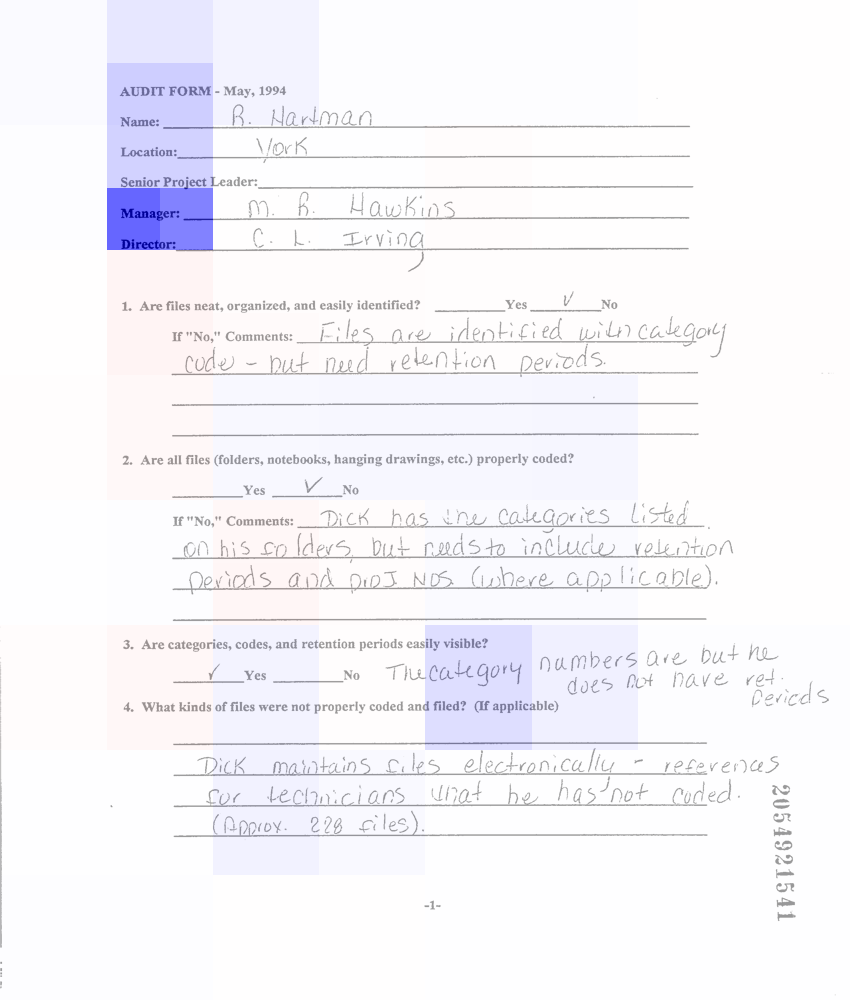

In [220]:
def shap_overlay(exp, alpha=0.6, cmap="bwr"):
    vals  = exp.values          # (H,W) or (H,W,3)
    img   = exp.data.astype(np.uint8)   # (H,W,3)

    if vals.ndim == 3:                   # SHAP gave per-channel values
        vals = vals.mean(2)              # collapse to one heat-map

    vmax  = np.abs(vals).max() + 1e-12
    norm  = (vals + vmax) / (2 * vmax)   # 0…1
    rgb   = plt.get_cmap(cmap)(norm)[..., :3] * 255  # (H,W,3) uint8
    blend = (img*(1-alpha) + rgb*alpha).astype(np.uint8)
    return Image.fromarray(blend)

shap_overlay(temp, alpha=0.6)


/tmp/ipython-input-242-4256015143.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color  = np.array(cm.get_cmap(cmap)((w+vmax)/(2*vmax))[:3]) * 255


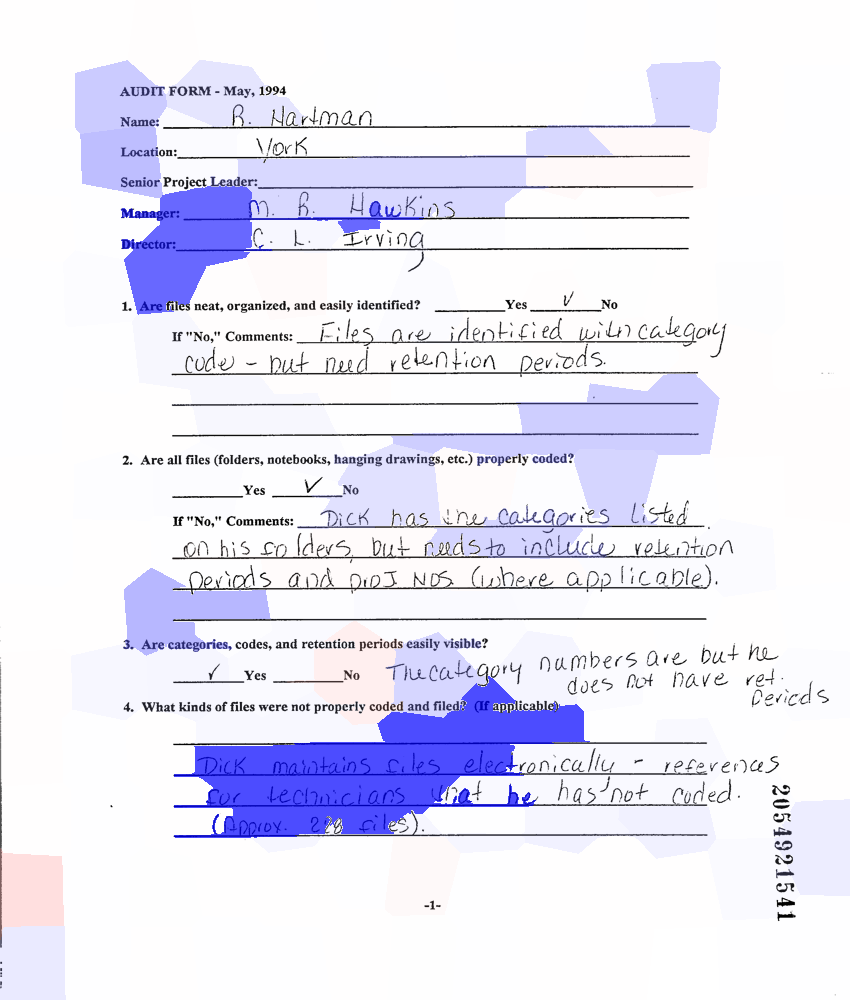

In [242]:
import numpy as np, matplotlib.pyplot as plt, matplotlib.cm as cm
from PIL import Image
from skimage.segmentation import slic

def lime_heatmap(expl, class_idx=4, alpha_max=0.6, cmap="bwr"):
    img     = expl.image.astype(float)                          # (H,W,3)
    segs    = expl.segments                                     # (H,W) labels
    weights = dict(expl.local_exp[class_idx])                   # {seg: w}
    vmax    = max(abs(w) for w in weights.values()) + 1e-12     # normaliser

    overlay = img.copy()
    for seg_id, w in weights.items():
        mask   = segs == seg_id                                 # (H,W) bool
        color  = np.array(cm.get_cmap(cmap)((w+vmax)/(2*vmax))[:3]) * 255
        alpha  = alpha_max * abs(w) / vmax                      # 0 → alpha_max
        overlay[mask] = overlay[mask]*(1-alpha) + color*alpha

    return Image.fromarray(overlay.astype(np.uint8))

# ---------------- example ----------------------------------------------
expl  = vision_explanations['LLMV3 lime']             # your LimeImageExplainer output
hm    = lime_heatmap(expl, class_idx=4, alpha_max=0.7)
hm

9.3340874e-05 -0.00065129995
-1.4066696e-05 -0.00070625544


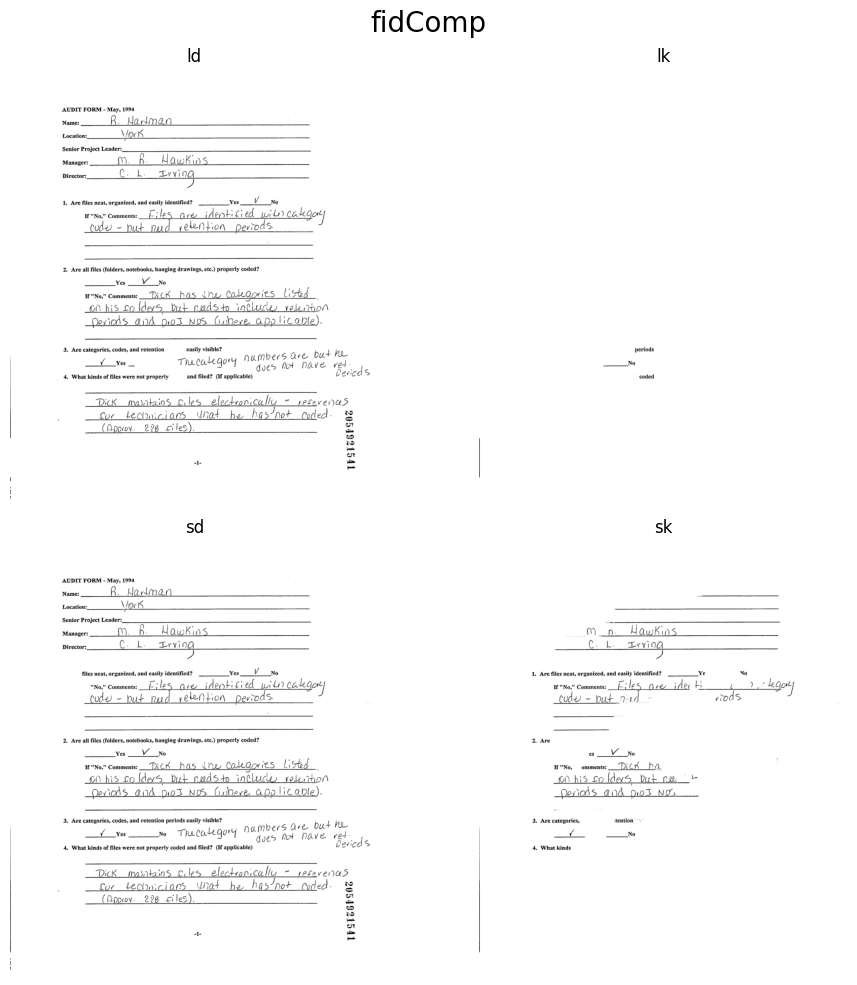

In [307]:
pred_f_l = vision_explainers['LLMV3 lime']._batched_predict
pred_f_s = vision_explainers['LLMV3 shap']._batched_predict
lime_drop, im1   = lime_comprehensiveness(pred_f_l, CLASH[0], vision_explanations['LLMV3 lime'],4, 2 )
lime_keep, im2   = lime_sufficiency(pred_f_l, CLASH[0], vision_explanations['LLMV3 lime'],4,2)
print(lime_drop, lime_keep)
# SHAP
shap_drop, im3   = shap_comprehensiveness(pred_f_l, CLASH[0], temp, 1)
shap_keep, im4   = shap_sufficiency(pred_f_l, CLASH[0], temp,50)
print(shap_drop, shap_keep)
display_image_grid([im1,im2,im3,im4], titles=['ld', 'lk', 'sd', 'sk'], grid_size=(2,2),main_title='fidComp')

In [292]:
def _predict_prob(predict_fn, sample):
    logits = predict_fn([sample])[0]
    if logits.ndim == 0:
        return 1 / (1 + np.exp(-logits))
    cls = np.argmax(logits)
    probs = 1 / (1 + np.exp(-logits))
    return probs[cls]


def _mask_image(img, mask, hide=(255, 255, 255)):
    out = img.copy()
    out[mask] = hide
    return out


def _doc_from_img(img_np, t):
    return DocSample(
        image=Image.fromarray(img_np),
        words=t.words,
        bboxes=t.bboxes,
        ner_tags=t.ner_tags,
        label=t.label,
    )


# -------- LIME -------------------------------------------------------------
def _topk_lime_segments(weights: dict, k: int):
    # keep only positive weights
    pos = {sid: w for sid, w in weights.items() if w > 0}
    if not pos:
        return []
    return sorted(pos, key=pos.get, reverse=True)[:k]


def lime_comprehensiveness(predict, sample, exp, class_idx, k=5):
    w = dict(exp.local_exp[class_idx])
    top = _topk_lime_segments(w, k)

    seg = exp.segments
    mask = np.isin(seg, top)

    img = np.asarray(sample.image.convert("RGB"))
    masked = _mask_image(img, mask)
    pert = _doc_from_img(masked, sample)

    d = _predict_prob(predict, sample) - _predict_prob(predict, pert)
    return d, Image.fromarray(masked)


def lime_sufficiency(predict, sample, exp, class_idx, k=5):
    w = dict(exp.local_exp[class_idx])
    top = _topk_lime_segments(w, k)

    seg = exp.segments
    mask = ~np.isin(seg, top)

    img = np.asarray(sample.image.convert("RGB"))
    masked = _mask_image(img, mask)
    pert = _doc_from_img(masked, sample)

    d = _predict_prob(predict, sample) - _predict_prob(predict, pert)
    return d, Image.fromarray(masked)


# -------- SHAP -------------------------------------------------------------
def _topk_shap_segments(vals, img_np, k,
                        n_segments=150, compactness=10, sigma=1):
    segs = slic(img_np, n_segments=n_segments,
                compactness=compactness, sigma=sigma, start_label=0)
    means = {sid: vals[segs == sid].mean() for sid in np.unique(segs)}
    pos = {sid: m for sid, m in means.items() if m > 0}
    if not pos:
        return np.zeros_like(vals, bool)  # no positive region
    top = sorted(pos, key=pos.get, reverse=True)[:k]
    return np.isin(segs, top)


def shap_comprehensiveness(predict, sample, exp, k=10, slic_kw=None):
    vals = exp.values.mean(2) if exp.values.ndim == 3 else exp.values
    img = np.asarray(sample.image.convert("RGB"))
    mask = _topk_shap_segments(vals, img, k, **(slic_kw or {}))

    masked = _mask_image(img, mask)
    pert = _doc_from_img(masked, sample)

    d = _predict_prob(predict, sample) - _predict_prob(predict, pert)
    return d, Image.fromarray(masked)


def shap_sufficiency(predict, sample, exp, k=10, slic_kw=None):
    vals = exp.values.mean(2) if exp.values.ndim == 3 else exp.values
    img = np.asarray(sample.image.convert("RGB"))
    keep = _topk_shap_segments(vals, img, k, **(slic_kw or {}))
    mask = ~keep

    masked = _mask_image(img, mask)
    pert = _doc_from_img(masked, sample)

    d = _predict_prob(predict, sample) - _predict_prob(predict, pert)
    return d, Image.fromarray(masked)

## DUMP

### Vision

In [ ]:
vision_explainer = LimeVisionExplainer(
    LLMV3,
    LLMV3_encode,
    batch_size=4,
    label = 4
)

vision_vals = vision_explainer.explain(CLASH[0], num_samples=1000, num_features=200)

  0%|          | 0/1000 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-236-2457376288.py", line 8, in <cell line: 0>
    vision_vals = vision_explainer.explain(CLASH[0], num_samples=1000, num_features=200)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/Interpretability-for-VRDU-models/Classification_Explain/lime.py", line 191, in explain
    return explainer.explain_instance(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/lime/lime_image.py", line 198, in explain_instance
    data, labels = self.data_labels(image, fudged_image, segments,
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/lime/lime_image.py", line None, in data_labels
KeyboardInterrupt

During handling of the ab

In [ ]:
print("Explanation score (R²):", vision_vals.score)

In [ ]:
segment_weights = dict(vision_vals.local_exp[2])

# Create weight map
segments = vision_vals.segments
weight_map = np.zeros_like(segments, dtype=float)
for seg_id, weight in segment_weights.items():
    weight_map[segments == seg_id] = weight

# Define overlay function
def lime_weight_to_overlay(image_np, weight_map, alpha=0.4):
    max_weight = np.max(np.abs(weight_map))
    if max_weight == 0:
        max_weight = 1
    normalized_weights = weight_map / max_weight
    r = np.where(normalized_weights > 0, 255,
                 np.where(normalized_weights < 0, 255 * (1 + normalized_weights), 255))
    g = np.where(normalized_weights > 0, 255 * (1 - normalized_weights),
                 np.where(normalized_weights < 0, 255 * (1 + normalized_weights), 255))
    b = np.where(normalized_weights > 0, 255 * (1 - normalized_weights),
                 np.where(normalized_weights < 0, 255, 255))
    color_map = np.stack([r, g, b], axis=-1).astype(np.uint8)
    overlay = ((1 - alpha) * image_np + alpha * color_map).clip(0, 255).astype(np.uint8)
    return overlay

# Apply overlay
img_np = vision_vals.image
heat_np = lime_weight_to_overlay(img_np, weight_map, alpha=0.4)

# Display
Image.fromarray(heat_np)

In [ ]:
from PIL import Image

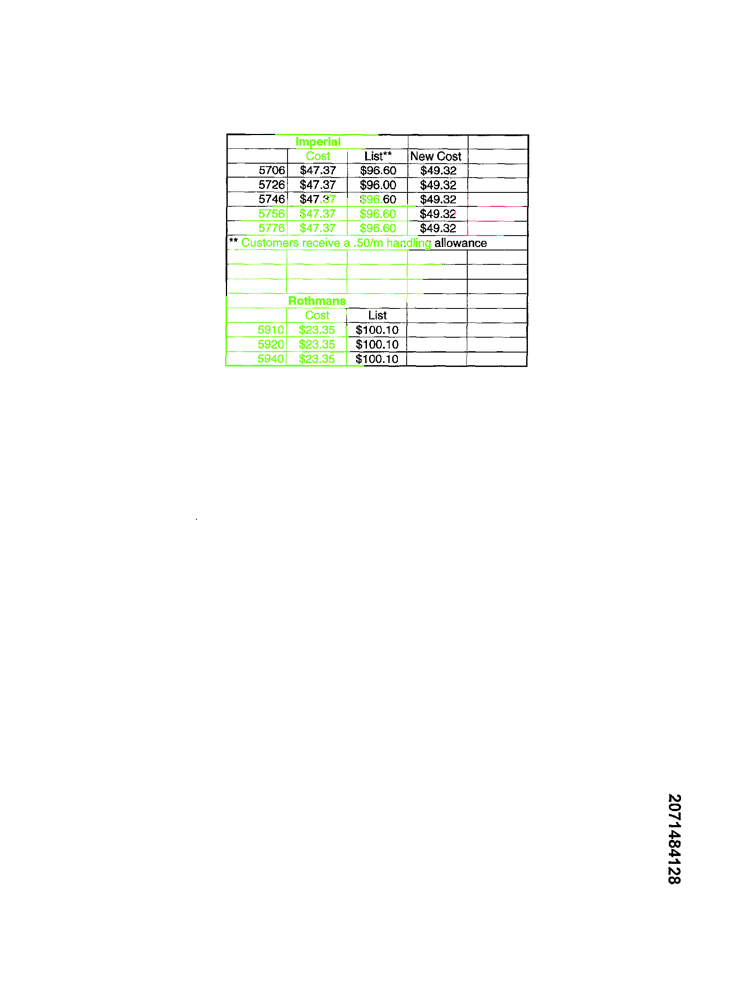

In [ ]:
img_np, mask = vision_vals.get_image_and_mask(
    label = 2,
    positive_only=False,   # include negative weights too
    num_features=30,
    hide_rest=False
)

heat_np = lime_mask_to_overlay(img_np, mask, alpha=0.40)
Image.fromarray(heat_np)

In [ ]:
print("Explanation score (R²):", vision_vals.score)
for word, weight in vision_vals:
  print(f"{word:10s} -> {weight:+.10f}")

Explanation score (R²): 0.4999955177896892


TypeError: 'ImageExplanation' object is not iterable

In [ ]:
text_explainer = LimeTextExplainer(
    LLMV3,
    LLMV3_encode,
    mask_token = LLMV3_proc.tokenizer.mask_token,
    batch_size = 2,
    kernel_width_factor = 0.75,
    labels = [4]
)

In [ ]:
text_vals = text_explainer.explain(AGREE[0], align_boxes=True, num_samples=2000, num_features=30)

Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT


[LIME] - Text: 100%|██████████| 1000/1000 [01:07<00:00, 14.85it/s]


In [ ]:
print("Explanation score (R²):", text_vals.score)
for word, weight in text_vals.as_list(label=4):
  print(f"{word:10s} -> {weight:+.10f}")

Explanation score (R²): 0.5400323868604897
TESTING=1  -> +0.3205282359
PERMIT=1   -> -0.2453773293
CIRCLE=1   -> +0.1232844989
09/14/00=1 -> -0.1213931989
7592605030=1 -> -0.1209888985
LEGAL=1    -> -0.1035435944
CHANGED=1  -> -0.0964325781
Date=1     -> -0.0920091476
FAX=1      -> -0.0919534823
phrases=1  -> +0.0746460957
VIRGINA=1  -> -0.0709158064
Ballot=1   -> +0.0688230427
01516960=1 -> -0.0609925024
CONSUMER=1 -> +0.0608734673
77=1       -> +0.0560616357
CHANGE=1   -> -0.0554682898
18042744780=1 -> -0.0534544893
each=1     -> +0.0481802885
Q=1        -> +0.0478539118
22014=1    -> -0.0478075509
P.O.=1     -> +0.0469367506
Due=1      -> -0.0458769306
PRODUCT=1  -> -0.0441783156
listed=1   -> +0.0435822464
the=1      -> +0.0428622151
OR=1       -> +0.0402991049
11:22=1    -> -0.0399912225
JOHN=1     -> -0.0357928618
LONG=1     -> +0.0328746740
a=1        -> +0.0315960852


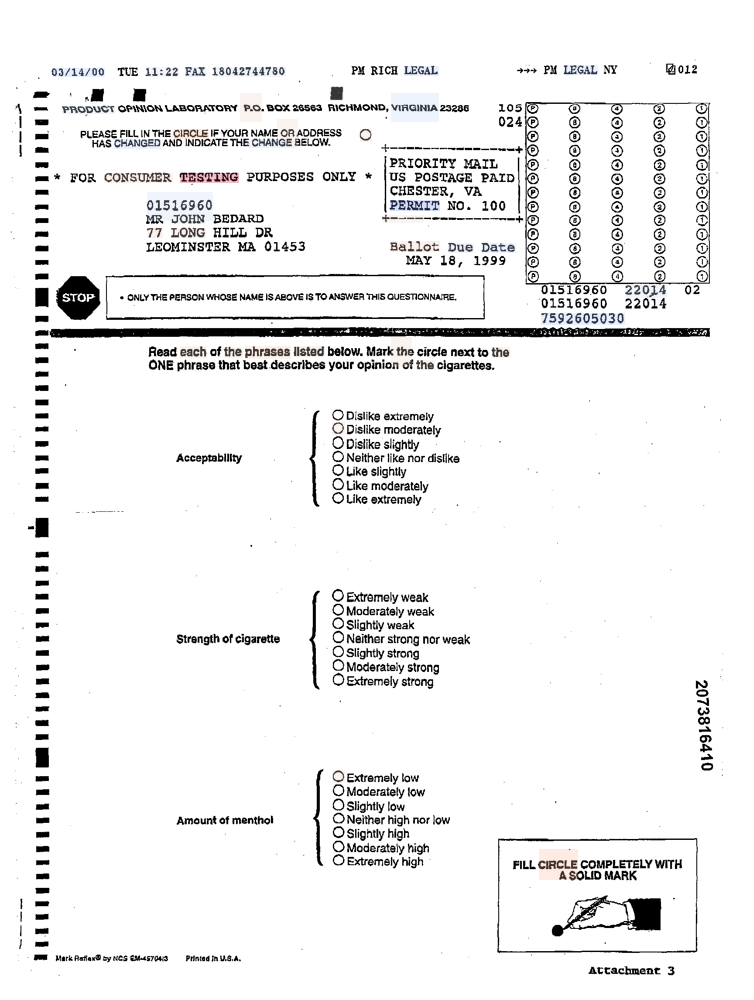

In [ ]:
from vrdu_utils.utils import draw_lime_token_heatmap
import re
weights = {}
for token, w in text_vals.as_list(label=4):
    clean = re.sub(r"=\d+$", "", token)     # drop '=number' suffix
    weights[clean] = weights.get(clean, 0.0) + w

draw_lime_token_heatmap(image = AGREE[0].image, words = AGREE[0].words, boxes = AGREE[0].bboxes, weights = weights, alpha = 0.25)

In [ ]:
fe_text = FidelityEvaluator(
    model = LLMV3,
    encode_fn = LLMV3_encode,
    device = device,
    mask_token = LLMV3_proc.tokenizer.mask_token
)

In [ ]:
len(AGREE[0].words)

41

In [ ]:
top20 = sorted(weights, key=weights.get, reverse=True)[: int(len(weights)*0.2)]

print("LIME feature strings:", top20[:10])
print("First 20 words in sample:", AGREE[0].words[:20])

# quick overlap check
print("Overlap size:",
      len({f.split('=')[0] for f in top20}.intersection(AGREE[0].words)))

LIME feature strings: ['Cost', 'handling', '$49.82', '$49.32', '$23.35,', '$23.95']
First 20 words in sample: ['Imperial', 'Tact]', 'L', 'Cost', '|', '5706|_$47.37', '$49.32', '|', '|', '5726|', '$47.37', '$49.82', '|', '|', '—5746|', '$47.37', '$49.32', '_|', '5756|', '$47.37']
Overlap size: 6


In [ ]:
orig = fe_text._get_prediction_function(AGREE[0].label)(AGREE[0])
pert = fe_text._get_prediction_function(AGREE[0].label)(
            DocSample(image=AGREE[0].image, words=["[UNK]"]*len(AGREE[0].words),
                      bboxes=AGREE[0].bboxes, ner_tags=AGREE[0].ner_tags, label=AGREE[0].label))
print(f"p_orig  = {orig:.6f}")
print(f"p_allUNK= {pert:.6f}")

p_orig  = 0.999919
p_allUNK= 0.000055


In [ ]:
scores = fe_text.evaluate(
    sample          = AGREE[0],
    explanation     = weights,
    top_k_fraction  = 0.2,          # use 20 % of the most important tokens
)
print(scores)
# {'$49.82', '$23.35', '$47.37', '$49.92,', '$23.35,', 'Cost', 'Imperial', '$49.32', 'handling', '$23.95'}
# {'$49.82', '$23.35', '$47.37', '$23.35,', 'Cost', 'Imperial', '$49.32', 'handling', '$23.95'}

dict_items([('TESTING', 0.3205282359193263), ('PERMIT', -0.24537732930020018), ('CIRCLE', 0.12328449890107587), ('09/14/00', -0.1213931988633826), ('7592605030', -0.12098889847925068), ('LEGAL', -0.10354359444888225), ('CHANGED', -0.09643257809098012), ('Date', -0.09200914757371348), ('FAX', -0.09195348232135804), ('phrases', 0.07464609571952292), ('VIRGINA', -0.07091580644369469), ('Ballot', 0.0688230427130549), ('01516960', -0.060992502389710615), ('CONSUMER', 0.060873467319759254), ('77', 0.056061635661395395), ('CHANGE', -0.055468289752155286), ('18042744780', -0.05345448929443866), ('each', 0.0481802885151693), ('Q', 0.04785391175292557), ('22014', -0.04780755093980096), ('P.O.', 0.04693675062595101), ('Due', -0.045876930620211864), ('PRODUCT', -0.04417831562019167), ('listed', 0.043582246366153064), ('the', 0.042862215108855135), ('OR', 0.040299104889327954), ('11:22', -0.03999122252246325), ('JOHN', -0.03579286181732051), ('LONG', 0.032874674032047205), ('a', 0.03159608518628525